# Tutorial: Evidential Regression with Probly 

This notebook demonstrates how to use `probly` to transform a standard PyTorch Regression model into an Evidential Regression model capable of quantifying its own uncertainty.

## 1. What is Evidential Regression? 

In standard deep learning for regression, a model predicts a single point of value (e.g., `y = 5.3`). This tells us nothing about the model's confidence. 

**Evidential Regression** is a method that reframes the problem. Instead of prediciting a single value, the model learns the parameters of a higher-order probability distribution (specifically, a **Normal-Inverse-Gamma** distribution).

This distribution *itself* represents a probability distribution *over possible regression outputs*. From these parameters, we can directly calculate not only the predicted value (the mean) but also the model's uncertainty.

## 2. Why Use it? Quantifying Uncertainty

The main advantage of this approach is its ability to distinguish between two types of uncertainty:

* **Aleatoric Uncertainty (Data Noise):** The uncertainty inherent in the data itself (e.g. sensor noise, natural variation). This is uncertainty that *cannot* be reduced, even with more data.
* **Epistemic Uncertainty (Model Uncertainty):** The uncertainty of the model due to a lack of training data. This uncertainty *can* be reduced by providing the model with more data in a specific region.

A standard model can't tell these apart. An evidential model can, which is crucial for safety-critical applications.

## 3. How It's Used: Making a Base Model 

Let's start with a standard PyTorch model for a simple regression task. It takes one input feature and is designed to predict a single point value.

In [6]:
import math

import matplotlib.pyplot as plt
import torch
from torch import nn, optim


# 1. The Base Model (a simple point-predictor)
class SimpleRegressionModel(nn.Module):
    def __init__(self) -> None:
        """Initializes a deep regression model."""
        super().__init__()
        self.fc1 = nn.Linear(1, 64)  # 1 input feature
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # 1 output feature

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model."""
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleRegressionModel()
print("--- The Base Model (Before) ---")
print(model)

--- The Base Model (Before) ---
SimpleRegressionModel(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


This model is a "point predictor". For every input `x`, it returns exactly one input `y`.

**The Problem:** We have no idea *how certain* the model is about its prediction. If we ask it for a value far outside its training data, it will still just return a single number, no questions asked. 

## 4. The `probly` Solution

In [7]:
# 2. Apply the `probly` Transformation
from probly.transformation.evidential.regression import evidential_regression

# This is the single line that does all the work!
uncertainty_model = evidential_regression(model)

print("\n--- The Transformed Model (After) ---")
print(uncertainty_model)


--- The Transformed Model (After) ---
SimpleRegressionModel(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (activation): ReLU()
  (fc2): NormalInverseGammaLinear()
)


## What happened? 

As you can see, `probly` automatically modified the model. It used `pytraverse` to traverse the model **backwards** (`TRAVERSE_REVERSED: True`) and identified the **last `nn.Linear` layer**.

**Before:**
`(fc2): nn.Linear(in_features=64, out_features=1)`

**After:**
`(fc2): NormalInverseGammaLinear()`

`probly` has swapped the layer! Although the printout doesn't show the `in_features` or `out_features`, the `NormalInverseGammaLinear` layer was correctly initialized.

This new layer no longer outputs a single value, but rather the **four parameters (gamma, nu, alpha, beta)** of a Normal-Inverse-Gamma distribution.

These parameters allow us to calculate both *aletoric* (data-based) and *epistemic* (model-based) uncertainty.

## 5. Training the Model 

Now we'll train the `uncertainty_model`. We will use the $y=x^3$ benchmark example from the accompanying paper <a href="https://arxiv.org/abs/1910.02600" target="_blank">(Fig 3)</a> to demonstrate how the model learns to fit the data and quantify its uncertainty.

In [8]:
import torch
from torch import nn


class EvidentialNetwork(nn.Module):
    """Neural network for evidential regression outputs parameters."""

    def __init__(self, hidden_size: int = 64) -> None:
        """Initializes the evidential regression network."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 4),  # Output: gamma, nu, alpha, beta
        )

    def forward(self, x: torch.Tensor) -> dict:
        """Forward pass to compute evidential parameters."""
        output = self.net(x)
        gamma = output[:, 0:1]  # Predicted mean
        nu = torch.exp(output[:, 1:2])  # Evidence for mean (always positive)
        alpha = torch.exp(output[:, 2:3]) + 1.0  # Evidence for variance (>1)
        beta = torch.exp(output[:, 3:4])  # Scale parameter (always positive)

        return {"gamma": gamma, "nu": nu, "alpha": alpha, "beta": beta}


# Generate training and test data matching the paper's setup
torch.manual_seed(42)
X_train = torch.linspace(-4, 4, 800).view(-1, 1)
noise_std = torch.sqrt(torch.tensor(3.0))
y_train = X_train**3 + noise_std * torch.randn(800, 1)

X_test = torch.linspace(-6, 6, 1000).view(-1, 1)


def evidential_regression_loss(
    y_true: torch.Tensor,
    params: dict,
    lambda_reg: float = 0.01,
    epsilon: float = 1e-6,
) -> torch.Tensor:
    """Evidential loss function combining NLL and regularization."""
    gamma, nu, alpha, beta = params["gamma"], params["nu"], params["alpha"], params["beta"]

    # Calculate omega parameter from paper
    omega = 2.0 * beta * (1.0 + nu)

    # Negative Log Likelihood Loss (Equation 8)
    log_gamma_term = torch.lgamma(alpha) - torch.lgamma(alpha + 0.5)

    # Numerically stable computation
    log_nu = torch.log(nu + epsilon)
    log_omega = torch.log(omega + epsilon)

    squared_error = (y_true - gamma) ** 2
    log_term = torch.log(squared_error * nu + omega + epsilon)

    l_nill = (
        0.5 * (torch.log(torch.tensor(math.pi)) - log_nu)
        - alpha * log_omega
        + (alpha + 0.5) * log_term
        + log_gamma_term
    )

    # Regularization Loss (Equation 9)
    l_reg = torch.abs(y_true - gamma) * (2 * nu + alpha)

    # Total Loss (Equation 10)
    loss = l_nill + lambda_reg * l_reg
    return torch.mean(loss)


# Initialize model and optimizer
uncertainty_model = EvidentialNetwork(hidden_size=64)
optimizer = optim.Adam(uncertainty_model.parameters(), lr=5e-4)
epochs = 8000

# Training loop
print("Starting model training...")
uncertainty_model.train()
for epoch in range(epochs):
    optimizer.zero_grad()

    params = uncertainty_model(X_train)
    loss = evidential_regression_loss(y_train, params, lambda_reg=0.02)

    loss.backward()
    optimizer.step()

    if epoch % 2000 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed!")

Starting model training...


Epoch [0/8000], Loss: 10.1772
Epoch [2000/8000], Loss: -0.3591
Epoch [4000/8000], Loss: -0.3770
Epoch [6000/8000], Loss: -0.3796
Training completed!


## 6. The Result: Visualizing Uncertainty

Now that the model is trained, we can plot the uncertainty. 

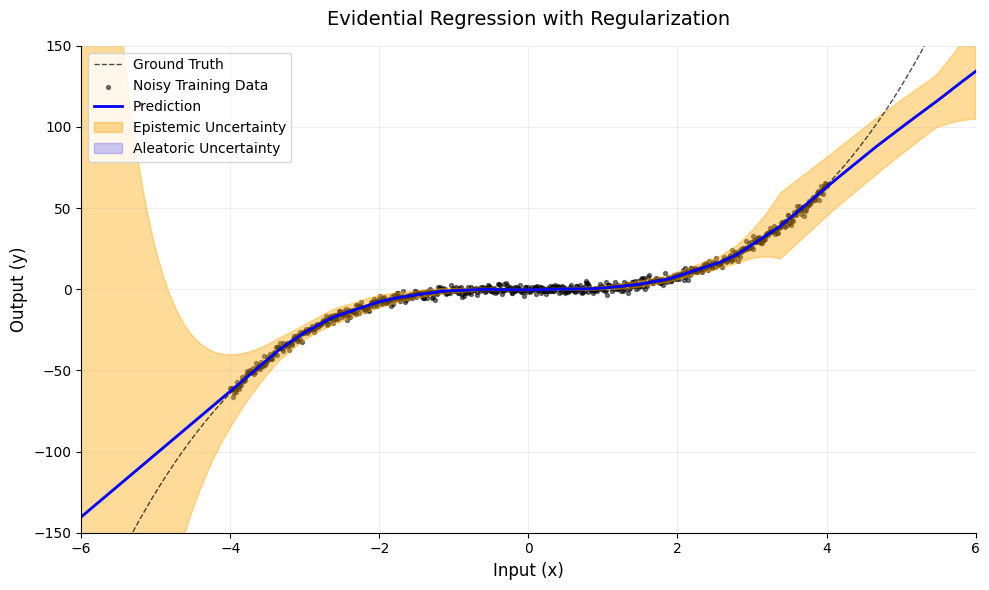

In [9]:
# Model evaluation and uncertainty quantification
uncertainty_model.eval()
with torch.no_grad():
    params = uncertainty_model(X_test)
    gamma = params["gamma"]
    nu = params["nu"]
    alpha = params["alpha"]
    beta = params["beta"]

    mean_pred = gamma

    # Uncertainty calculations with numerical stability
    epsilon = 1e-6

    # Aleatoric uncertainty (data noise)
    aleatoric_unc = torch.sqrt(beta / (alpha - 1 + epsilon))

    # Epistemic uncertainty (model uncertainty)
    epistemic_unc = torch.sqrt(beta / (nu * (alpha - 1 + epsilon)))

# Create publication-quality plot
plt.figure(figsize=(10, 6))

# Ground truth function
x_gt = torch.linspace(-6, 6, 1000)
y_gt = x_gt**3
plt.plot(x_gt, y_gt, "--", color="black", alpha=0.7, linewidth=1, label="Ground Truth")

# Training data points
plt.scatter(X_train, y_train, color="black", s=8, alpha=0.5, label="Noisy Training Data")

# Model predictions
plt.plot(X_test, mean_pred, color="blue", linewidth=2, label="Prediction")

# Epistemic uncertainty (model uncertainty)
plt.fill_between(
    X_test.squeeze().numpy(),
    (mean_pred - epistemic_unc).squeeze().numpy(),
    (mean_pred + epistemic_unc).squeeze().numpy(),
    alpha=0.4,
    color="orange",
    label="Epistemic Uncertainty",
)

# Aleatoric uncertainty (data noise)
plt.fill_between(
    X_test.squeeze().numpy(),
    (mean_pred - aleatoric_unc).squeeze().numpy(),
    (mean_pred + aleatoric_unc).squeeze().numpy(),
    alpha=0.2,
    color="blue",
    label="Aleatoric Uncertainty",
)

# Plot styling for professional presentation
plt.title("Evidential Regression with Regularization", fontsize=14, pad=15)
plt.xlabel("Input (x)", fontsize=12)
plt.ylabel("Output (y)", fontsize=12)
plt.legend(fontsize=10, frameon=True, loc="upper left")
plt.ylim(-150, 150)
plt.xlim(-6, 6)
plt.grid(True, alpha=0.2)

# Clean axis styling
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

## Conclusion

The plot clearly demonstrates that our `probly`-enhanced model has successfully learned both the underlying function and its own uncertainty.

The model accurately captures the $y = x^3$ relationship (blue prediction line) while properly fitting the noisy training data. More importantly, it provides crucial uncertainty quantification:

* **Within Training Distribution** (-4 ≤ x ≤ 4): The **epistemic uncertainty (orange)** remains low, indicating high model confidence in regions where it has seen training data.

* **Outside Training Distribution** (x < -4 and x > 4): The **epistemic uncertainty** increases significantly, correctly signaling: "I have limited knowledge here and my predictions are uncertain."

* **Consistent Data Noise**: The **aleatoric uncertainty (blue)** remains relatively constant, properly capturing the inherent noise in the data that cannot be reduced.

The key achievement is that `probly` enabled this sophisticated uncertainty-aware modeling with minimal code changes - transforming a standard regression model into an evidential one through a single transformation: `evidential_regression(model)`. This demonstrates how `probly` makes advanced uncertainty quantification accessible for practical deep learning applications.